In [0]:
import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
import matplotlib
import torch 
import torch.nn as nn
from tqdm.auto import tqdm
from torch.distributions import Normal, MultivariateNormal, Uniform
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

In [0]:
DEVICE = torch.device('cpu')

In [0]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [0]:
X, y = sample_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125)
train_loader = torch.utils.data.DataLoader(torch.from_numpy(X_train), batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.from_numpy(X_val), batch_size=256)
test_loader = torch.utils.data.DataLoader(torch.from_numpy(X_test), batch_size=256)
    

In [0]:
class Model(nn.Module):
    def __init__(self, k):
        super(Model, self).__init__()
        self.k = k
        self.pi1 = nn.Parameter(torch.randn(self.k, requires_grad=True))
        self.softmax = nn.Softmax(dim=-1)
        self.mu1 = nn.Parameter(torch.randn(self.k, requires_grad=True))
        self.sigma1 = nn.Parameter(torch.randn(self.k, requires_grad=True))
        self.pi2 = nn.Sequential(nn.Linear(1, k),
                                nn.Softmax(dim=1))
        self.mu2 = nn.Sequential(nn.Linear(1, k))
        self.sigma2 = nn.Sequential(nn.Linear(1, k))

    def forward(self,x):
        x1, x2 = x[:, 0], x[:, 1]

        pi1 = self.softmax(self.pi1)
        mu1 = self.mu1
        sigma1 = self.sigma1
        pi2 = self.pi2(x1.view(-1, 1))
        mu2 = self.mu2(x1.view(-1, 1))
        sigma2 = self.sigma2(x1.view(-1, 1))

        p1 = torch.zeros(x.shape[0]).to(DEVICE)
        p2 = torch.zeros(x.shape[0]).to(DEVICE)

        for i in range(self.k):
            p1 += pi1[i] * Normal(mu1[i], torch.exp(sigma1[i])).log_prob(x1).exp()
            p2 += pi2[:, i] * Normal(mu2[:, i], torch.exp(sigma2[:, i])).log_prob(x2).exp()

        return p1 * p2

    def latent(self, x):
        x1, x2 = x[:, 0], x[:, 1]

        pi1 = self.softmax(self.pi1)
        mu1 = self.mu1
        sigma1 = self.sigma1
        pi2 = self.pi2(x1.view(-1, 1))
        mu2 = self.mu2(x1.view(-1, 1))
        sigma2 = self.sigma2(x1.view(-1, 1))

        z1 = torch.zeros(x.shape[0]).to(DEVICE)
        z2 = torch.zeros(x.shape[0]).to(DEVICE)

        for i in range(self.k):
            z1 += pi1[i] * Normal(mu1[i], torch.exp(sigma1[i])).cdf(x1)
            z2 += pi2[:, i] * Normal(mu2[:, i], torch.exp(sigma2[:, i])).cdf(x2)
        return z1, z2
    
    def sample(self, x):
        z1, z2 = z[:, 0], z[:, 1]
        x1 = torch.zeros(z.shape[0]).to(DEVICE)
        pi1 = self.softmax(self.pi1)
        mu1 = self.mu1
        sigma1 = self.sigma1
       
        for i in range(z.shape[0]):
            j = np.random.choice(self.k, p=pi1.detach().numpy())
            x1[i] = Normal(mu1[j], torch.exp(sigma1[j])).icdf(z1[i])
       
        pi2 = self.pi2(x1.view(-1, 1))
        mu2 = self.mu2(x1.view(-1, 1))
        sigma2 = self.sigma2(x1.view(-1, 1))


        x2 = torch.zeros(z.shape[0]).to(DEVICE)
        for i in range(z.shape[0]):
            j = np.random.choice(self.k, p=pi2[i].detach().numpy())
            x2[i] = Normal(mu2[i, j], torch.exp(sigma2[i, j])).icdf(z2[i])

        return x1, x2
    
    def __call__(self, x):
        return self.forward(x)

In [0]:
def Loss(x):
    return -torch.mean(torch.log(x)) / 2

In [0]:
def train(model, train_loader, val_loader, test_loader, optimizer, loss_function, epoch_cnt, batch_size):
    train_loss_values = []
    val_loss_values = []
            
    for epoch in tnrange(epoch_cnt, desc='Epoch'):
        for batch_data in train_loader:
            x = batch_data.float().to(DEVICE)
            optimizer.zero_grad()
            output = model(x)
            loss = loss_function(output)
            train_loss_values.append(loss)
            loss.backward()
            optimizer.step()

        loss_values = []
        for batch_data in val_loader:
            x = batch_data.float().to(DEVICE)
            output = model(x)
            loss = loss_function(output)
            loss_values.append(loss.item())
        val_loss_values.append(np.mean(np.array(loss_values)))
        print("Epoch " + str(epoch) + " done")

    loss_values = []
    for batch_data in test_loader:
        x = batch_data.float().to(DEVICE)
        output = model(x)
        loss = loss_function(output)
        loss_values.append(loss.item())

    print("Test set loss: {:.3f}".format(np.mean(np.array(loss_values))))
    
    return train_loss_values, val_loss_values

In [0]:
K = 6
BATCH_SIZE = 256
EPOCHS_CNT = 25

In [0]:
model = Model(K)
model = model.float()
model = model.to(DEVICE)

In [0]:
loss_function = Loss
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [291]:
train_loss_values, val_loss_values =\
    train(model, train_loader, val_loader, test_loader, optimizer, loss_function, EPOCHS_CNT, BATCH_SIZE)

Epoch 0 done
Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done
Epoch 11 done
Epoch 12 done
Epoch 13 done
Epoch 14 done
Epoch 15 done
Epoch 16 done
Epoch 17 done
Epoch 18 done
Epoch 19 done
Epoch 20 done
Epoch 21 done
Epoch 22 done
Epoch 23 done
Epoch 24 done
Test set loss: 0.679


In [0]:
def plot_loss_values(train_loss_values, val_loss_values):
    plt.plot(np.arange(len(train_loss_values)), train_loss_values, color='blue', label='train')
    plt.plot(np.arange(0, len(train_loss_values), len(train_loss_values) / EPOCHS_CNT), val_loss_values, color='red', label='validation')
    plt.legend()
    plt.title("Loss values")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

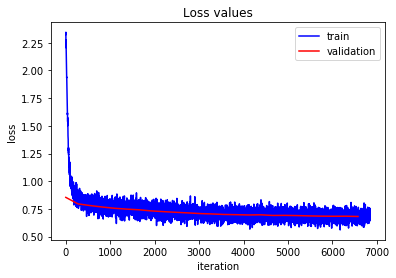

In [293]:
plot_loss_values(train_loss_values, val_loss_values)

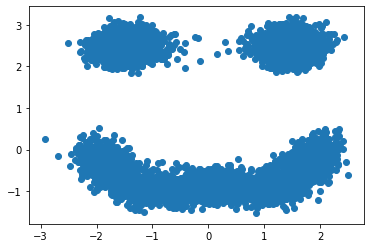

In [294]:
low = torch.tensor([0.0]).to(DEVICE)
high = torch.tensor([1.0]).to(DEVICE)
z = Uniform(low, high).rsample((10000, 2))
x1, x2 = model.sample(z)
x1 = x1.cpu().detach().numpy()
x2 = x2.cpu().detach().numpy()
plt.figure()
plt.scatter(x1, x2)

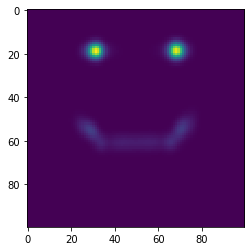

In [295]:
d = np.linspace(-4, 4, 100)
samples = np.array(np.meshgrid(d, d)).T.reshape([-1, 2])
samples = torch.from_numpy(samples).float().to(DEVICE)
pdf = model(samples).cpu().detach().numpy().reshape(100, 100)
plt.imshow(np.rot90(pdf, 1))

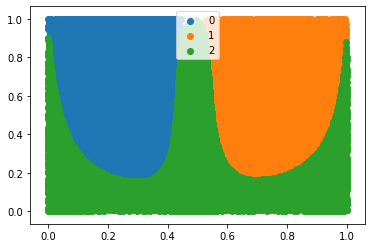

In [297]:
x = torch.from_numpy(X).float().to(DEVICE)
z1, z2 = model.latent(x)
z1 = z1.cpu().detach().numpy()
z2 = z2.cpu().detach().numpy()
plt.figure()
plt.scatter(z1[y == 0], z2[y == 0], label='0')
plt.scatter(z1[y == 1], z2[y == 1], label='1')
plt.scatter(z1[y == 2], z2[y == 2], label='2')
plt.legend()